In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
# leggo il dataset ed il target

dataset = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\exploiting blockchain - cleaned\dataset.csv', header = 0)
features_names = list(dataset.columns) # ottengo i nomi delle features
features_names.pop(0) # rimuovo il primo addresses, in quanto non e' una feature
pairs_number_features = list() # creo una lista che contiene coppie <#_feature, nome_feature>
idx = 0

while idx < len(features_names):
    pair = (idx, features_names[idx])
    pairs_number_features.append(pair)
    idx+=1
    
print(pairs_number_features)

target = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\exploiting blockchain - cleaned\target.csv', header = 0)

[(0, 'balance'), (1, 'N_maxpayment'), (2, 'investment_in'), (3, 'payment_out'), (4, 'mean_v1'), (5, 'sdev_v1'), (6, 'skew_v1'), (7, 'mean_v2'), (8, 'sdev_v2'), (9, 'skew_v2'), (10, 'known_rate'), (11, 'paid_rate'), (12, 'paid_one')]


In [3]:
X = dataset.values[:, 1:] # rimuovo la prima colonna che contiene gli indirizzi
y = target.values

# divido in train set (TR) e test set (TS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 

In [4]:
# vado a stampare il numero di non ponzi e ponzi presenti nel train set e nel test_set
flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
print('Number of smart contract in train set::', flat_list_train.count(0))
print('Number of smart Ponzi in train set::', flat_list_train.count(1))
flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
print('Number of smart contract in test set::', flat_list_test.count(0))
print('Number of smart Ponzi in test set::', flat_list_test.count(1))

Number of smart contract in train set:: 3107
Number of smart Ponzi in train set:: 538
Number of smart contract in test set:: 777
Number of smart Ponzi in test set:: 135


In [5]:
model_params = {
    'decision_tree' : {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [6, 7, 8, 9, None],
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[20,40,60,80,100,120,140,160,180,200],
            'criterion':['gini', 'entropy'],
            'bootstrap': [True, False]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier( eval_metric = 'aucpr',  use_label_encoder = False),
        'params': {
                'n_estimators' : [100,110,120,130,140,150,160,170,180,190,200],
                'learning_rate': [0.1,0.2,0.3],
                'max_depth': [3,6,8,9]
        }
    }
}

In [6]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_jobs=8)
    clf.fit(X_train, y_train.ravel())
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_ # necessario per riallenare
    })
    
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,decision_tree,0.869410,"{'criterion': 'entropy', 'max_depth': 7}"
1,random_forest,0.877915,"{'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 100}"
2,xgboost,0.879835,"{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}"


In [7]:
models_list = sorted(scores, key=lambda d: d['best_score']) # ordino in base al best_score
model = models_list[-1] # prendo l'ultimo modello (quello con score piu' alto)
clf = model.get('best_estimator') # ottengo i valori con cui allenare
clf.fit(X_train, y_train) # rialleno

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

precision score::  0.6451612903225806
recall score::  0.2962962962962963
accuracy score::  0.8717105263157895
F1 score:: 0.40609137055837563


<AxesSubplot:>

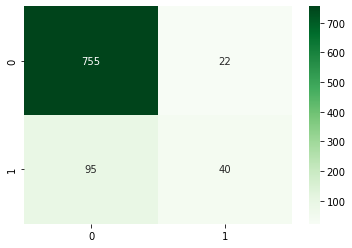

In [8]:
y_pred = clf.predict(X_test)
#print(clf.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred)) # TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred))	     # TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred))	 # (TP + TN)/ (TP + FN + TN + FP)
print('F1 score::', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')